<a href="https://colab.research.google.com/github/pfaendler/ETH_SysBio_Exercises/blob/main/SysBio_ROC_PR_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) ROC and PR curves - Introduction
Developments in machine learning have enabled biologists to build models for various classification tasks (e.g. WT mouse vs. KO mouse). In this exercise we are going to learn how to assess the perfomance of a model (how good or how bad it is) using different metrics including "Receiver Operating Characteristic" (ROC) or "Precision Recall" (PR) curves. 

To do so, we first need to define some terms, which will help us to understand these details behind these metrics.

Commonly, we would like to predict to which class a sample belongs to with our model. This will result in 4 different possibilities:

 - True Positives (TP) - both actual value and prediction are 'true' (e.g. WT mouse predicted to be WT)
 - False Positives (FP) - actual value is 'false' and prediction is 'true' (e.g. KO mouse predicted to be WT)
 - False Negatives (FN) - actual value is 'true' and prediction is 'false' (e.g. WT mouse predicted to be KO)
 - True Negatives (TN) - both actual value and prediction are 'false' (e.g. KO mouse predicted to be KO)

These resulting values can be visualised in a so-called 'confusion matrix':


<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/04/Basic-Confusion-matrix.png' width=300px><br> 
<em>**Figure 1:** Schematic confusion matrix <br> (copied from https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/) </em>

And from here, different metrics can be calculated:

 - Specificity = $TN \over TN + FP $
 - Precision = $TP \over TP + FP $
 - False Positive Rate = $FP \over TN + FP $ = 1 - Specificity 
 - True Positive Rate = Sensitivity = Recall = $TP \over TP + FN $

These metrics are the baseline for ROC and PR curves, which help us to display the performance of a model in a graphical way.


# 2) Example - Covid-19 Saliva Test
Let's look at these different metrics in an easier example. Suppose you have developed a COVID-19 test that can be used to detect the presence of the virus in a patient's saliva sample. Your test gives a numerical score ranging from 0 to 100, with higher scores indicating an increased chance of being COVID-19 positive. You want to evaluate the performance of your test using different metrics. 

For the purpose of this example, we will create the data ourselves. 



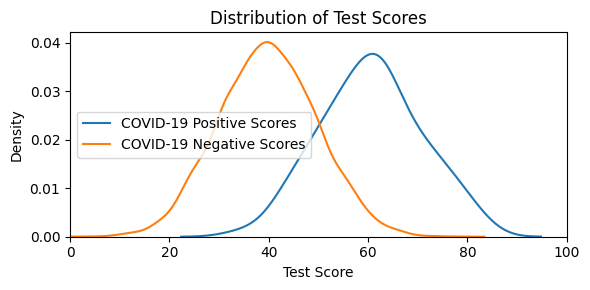

In [1]:
# we first need to import some python modules 
import numpy as np #for matrix manipulations 
import matplotlib.pyplot as plt # for plotting
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve # to display different metrics & curves
import seaborn as sns # for density plots

# Simulate a COVID-19 test dataset with 5000 patients, of which 100 are covid positive.
np.random.seed(0) #for reproducibility
n_patients = 5000
n_covid_pos = 100
n_covid_neg = n_patients - n_covid_pos

# We create our saliva test results by drawing from two different normal distributions using different means for each group. 
# This means, on average, the scores of covid pos. are higher, but the two distributions overlap.
covid_pos_scores = np.random.normal(loc=60, scale=10, size=n_covid_pos)
covid_neg_scores = np.random.normal(loc=40, scale=10, size=n_covid_neg)

# Combine the saliva test results in 'test_scores' and save the true label (in both np.arrays the first 100 are the positive ones)
test_scores = np.concatenate((covid_pos_scores, covid_neg_scores))
true_labels = np.concatenate((np.ones(n_covid_pos), np.zeros(n_covid_neg)))

# Can you show the overlap of the two distributions? QUESTION FOR STUDENTS?
plt.figure(figsize=(6, 3))
sns.kdeplot(covid_pos_scores,  label='COVID-19 Positive Scores')
sns.kdeplot(covid_neg_scores,  label='COVID-19 Negative Scores')
plt.xlabel('Test Score')
plt.xlim([0, 100])
plt.ylabel('Density')
plt.title('Distribution of Test Scores')
plt.legend()

plt.tight_layout()
plt.show()


What do you think would be a good threshold here?


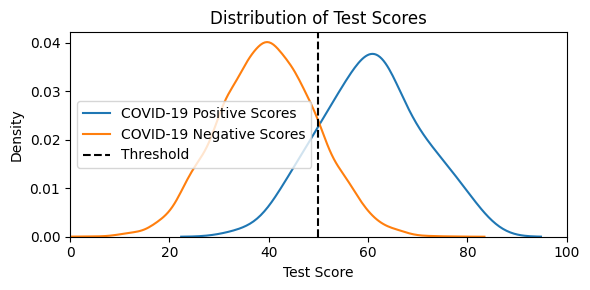

85 747 4153 15


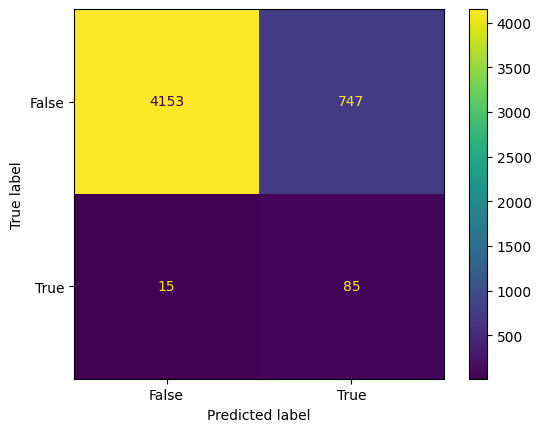

0.10216346153846154
0.85
0.15244897959183673


In [3]:
# Now, assume that our test sets the thresholds at 50 (which is more or less dividing the two distributions). Using this threshold, we can now take a look at the different metrics. 
plt.figure(figsize=(6, 3))
sns.kdeplot(covid_pos_scores,  label='COVID-19 Positive Scores')
sns.kdeplot(covid_neg_scores,  label='COVID-19 Negative Scores')
plt.axvline(x=50, color='black', linestyle='--', label='Threshold') # Question: Can you visualise the threshold? (use plt.axvline)
plt.xlabel('Test Score')
plt.xlim([0, 100])
plt.ylabel('Density')
plt.title('Distribution of Test Scores')
plt.legend()

plt.tight_layout()
plt.show()

# Similar to the 'true_labels' create the 'test_labels' based on a threshold of 50 QUESTION?
test_labels = test_scores>50

# Calculate the four different values introduced in 1.1
tp = np.sum((true_labels ==1) & (test_labels ==True))
fp = np.sum((true_labels ==0) & (test_labels ==True)) #QUESTION
tn = np.sum((true_labels ==0) & (test_labels ==False)) #QUESTION
fn = np.sum((true_labels ==1) & (test_labels ==False)) #QUESTION

print(tp, fp, tn, fn)

# Can you also visualise this in a confusion matrix?
confusion_matrix = metrics.confusion_matrix(true_labels, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


# Calculate the different metrics introduced in chapter 1.1 based on a threshold of 50
precision = tp/(tp+fp)
print(precision)
recall = tp/(tp+fn)
print(recall)
false_pos_rate = fp/(tn+fp)
print(false_pos_rate)

What do these values mean for our saliva test with a threshold of 50? QUESTION?


1) Our Covid-19 test has a precision of 0.102 at threshold 50, meaning that 
when it predicts a patient is Covid-19 positive, it is correct in 10.2% of the cases. \\
2)  The saliva test, at threshold 50 has a recall of 0.85, meaning it correctly identifies 85% of all Covid-19 positive cases.



At this threshold our test does not work very well, it gives quite a high number of false positives. But what would we want from our test? QUESTION? \\



# 3) ROC curve

Instead of setting the threshold manually, we can also look how this binary classification for our test works across thresholds. To do this, we can use a ROC curve.
A ROC curve is a graphical representation of the performance of a binary classifier across different thresholds and is based on the false positive rate (FPR) on the x-axis and the true positive rate (TPR) on the y-axis.

<img src='https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg' width=500px><br> 
<em>**Figure 2:** Schematic ROC curve <br> (copied from https://commons.wikimedia.org/wiki/File:Roc_curve.svg) </em>2


As you can see, a perfect classifier would have a ROC curve that passes through the top left corner of the graph, whereas a random classifier would have a ROC curve that goes diagonally from the bottom left to the top right.
In reality, these curves are often somewhere in between the two extremes.


ROC curves can also be described in a quantiative way, which is commonly referred to as the respective ROC curve's 'Area Under Curve' (AUC, also known as AUROC, area under receiver operating characteristic) value. While a perfect classifier would have an AUC of 1, a random classifier would have a value of 0.5. 



Let us revisit our previous example from a ROC curve perspective:

0.9291244897959183


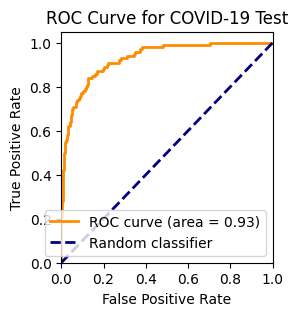

In [4]:
# using the function 'roc_curve' from sklearn.metrics we can retrieve the fpr, tpr, etc. from our example
fpr, tpr, thresholds = roc_curve(true_labels, test_scores)
# we can also calculate the auc
roc_auc = auc(fpr, tpr)
print(roc_auc)

# Plot the ROC curve
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label = 'Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for COVID-19 Test')
plt.legend(loc="lower right")
plt.show()


Would you consider our saliva test to perform well in this binary classification?

Can you display, where on the curve our previously used threshold lies?

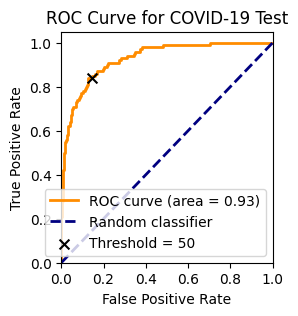

In [6]:

# Where can we find our previous threshold of 50 in this plot?
idx = np.argmin(np.abs(fpr - false_pos_rate))

plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random classifier')
plt.scatter(fpr[idx], tpr[idx],zorder = 2, marker= 'x', color='black', s=50, label=f'Threshold = 50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for COVID-19 Test')
plt.legend(loc="lower right")

plt.show()

## Questions

1) Where would you draw a threshold for our test?\
2) According to the ROC curve's AUC the saliva test performs quite well, what do you think about it if you look at the confusion matrix?\
3) Can you explain why the AUC is that high?


# 4) PR curves

Another graphical representation to check the performance of a binary classifier is the PR (precision-recall) curve. In a PR curve, the x-axis represents the recall or sensitivity, which is the proportion of true positives (instances correctly classified as positive) out of all the actual positives in the dataset. The y-axis represents the precision or positive predictive value (PPV), which is the proportion of true positives out of all the instances classified as positive by the classifier. The PR curve summarises the trade-off between precision and recall for different classification thresholds.

Let's revisit our Covid-19 saliva test with PR curves. 

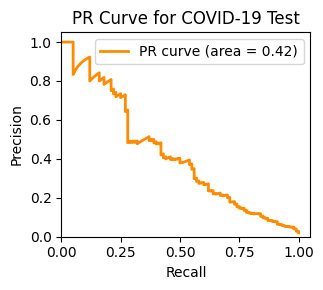

In [ ]:
# Calculate the precision and recall for different discrimination thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, test_scores)
pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure(figsize=(6, 3))
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for COVID-19 Test')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

## Questions
1) Why is the score of the PR curve so low? \
2) When do you think is a PR curve more appropriate?

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc


# Generate dataset
np.random.seed(42)
n = 5000
metadata = np.random.rand(n)  # email metadata
keywords = np.random.rand(n)  # presence of keywords
allcaps = np.random.rand(n)  # use of all caps
punctuation = np.random.rand(n)  # excessive punctuation
html = np.random.rand(n)  # HTML content

# Only metadata and keywords are informative
spam_prob = 1 / (1 + np.exp(-(-1.5*metadata + 2*keywords + 0.5*allcaps - 0.5*punctuation - 0.5*html)))
labels = np.random.binomial(n=1, p=spam_prob)

# Combine features and labels into a pandas dataframe
data = pd.DataFrame({'Metadata': metadata, 'Keywords': keywords, 'AllCaps': allcaps,
                     'Punctuation': punctuation, 'HTML': html, 'Label': labels})



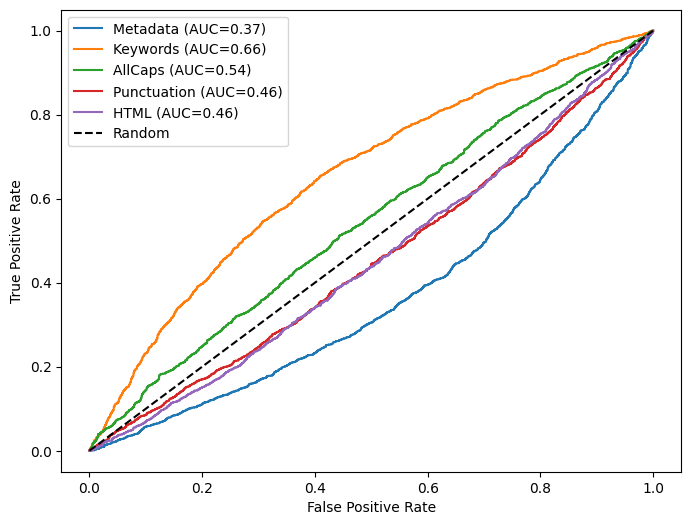

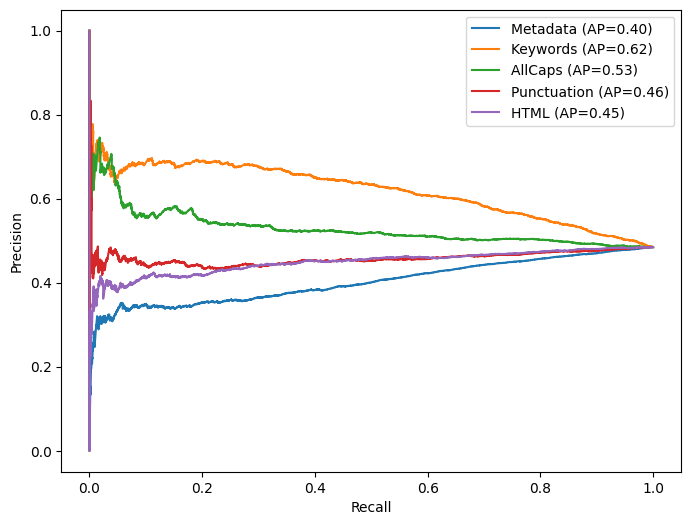

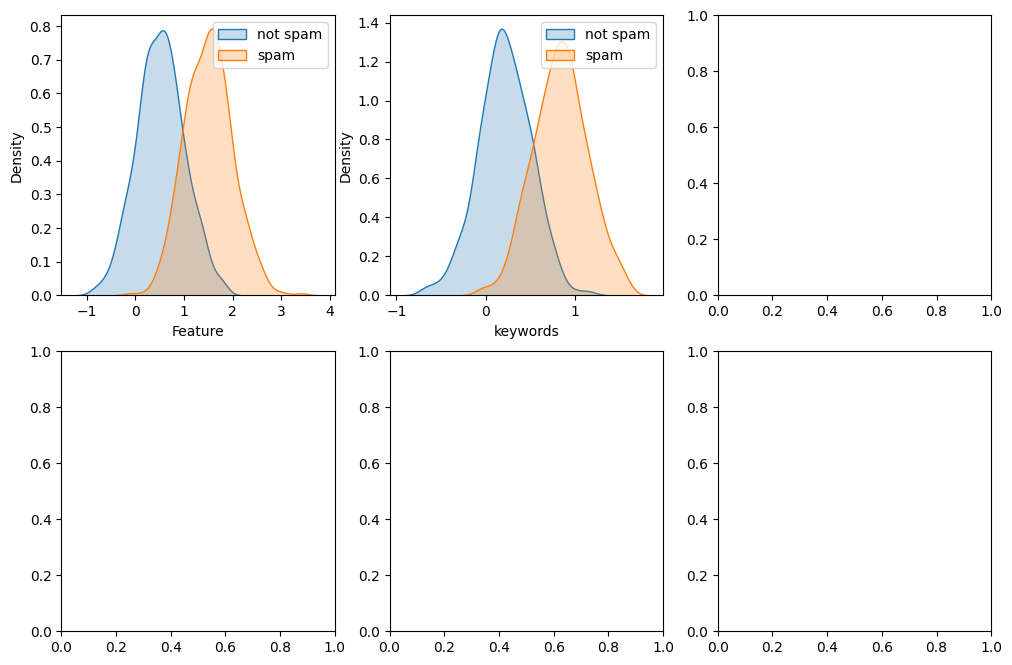

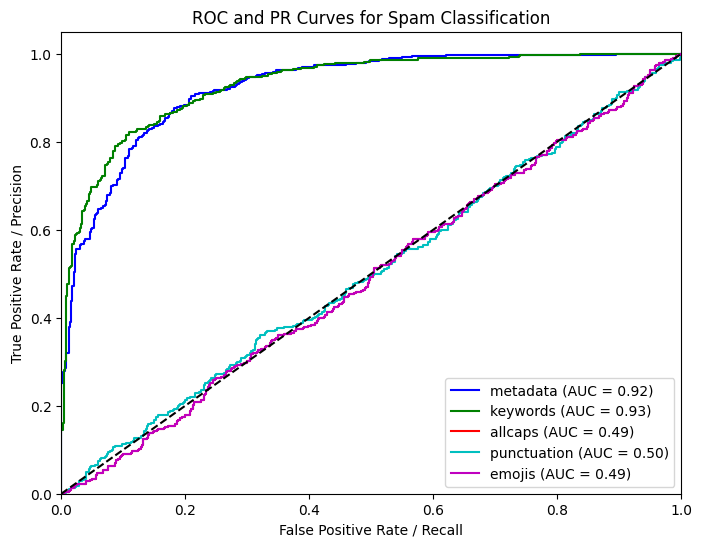

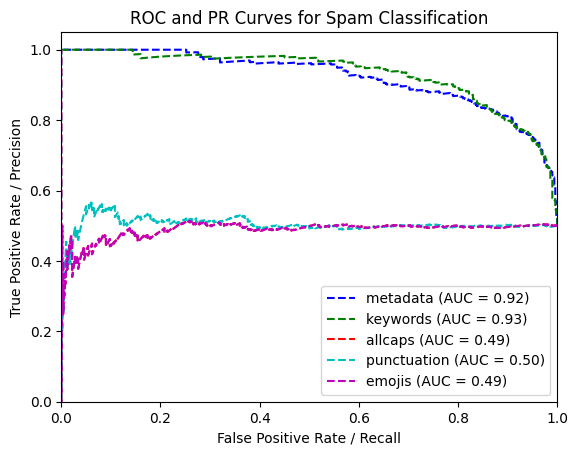

In [36]:
# Generate a synthetic dataset
np.random.seed(42)
n_samples = 1000
spam_prop = 0.5

metadata_spam_mean = 1.5
metadata_spam_std = 0.5
metadata_nospam_mean = 0.5
metadata_nospam_std = 0.5

keywords_spam_mean = 0.8
keywords_spam_std = 0.3
keywords_nospam_mean = 0.2
keywords_nospam_std = 0.3

metadata = np.concatenate([
    np.random.normal(metadata_spam_mean, metadata_spam_std, size=int(spam_prop*n_samples)),
    np.random.normal(metadata_nospam_mean, metadata_nospam_std, size=int((1-spam_prop)*n_samples))
])

keywords = np.concatenate([
    np.random.normal(keywords_spam_mean, keywords_spam_std, size=int(spam_prop*n_samples)),
    np.random.normal(keywords_nospam_mean, keywords_nospam_std, size=int((1-spam_prop)*n_samples))
])

content = np.random.normal(0, 1, size=n_samples*2)
labels = np.concatenate([np.ones(int(spam_prop*n_samples)), np.zeros(int((1-spam_prop)*n_samples))])

df = pd.DataFrame({
    "metadata": metadata,
    "keywords": keywords,
    "allcaps": content[:n_samples],
    "punctuation": content[n_samples:],
    "emojis": content[:n_samples],
    "label": labels
})


# save this dataframe so that students can load it themselves

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
sns.kdeplot(df[labels == 0]['metadata'], ax=axs[0, 0], fill=True, label='not spam')
sns.kdeplot(df[labels == 1]['metadata'], ax=axs[0, 0], fill=True, label='spam')
axs[0, 0].set_xlabel('Feature')
axs[0, 0].legend()

sns.kdeplot(df[labels == 0]['keywords'], ax=axs[0, 1], fill=True, label='not spam')
sns.kdeplot(df[labels == 1]['keywords'], ax=axs[0, 1], fill=True, label='spam')
axs[0, 1].set_xlabel('keywords')
axs[0, 1].legend()
plt.show()








# Compute ROC and PR curves for all features
features = ["metadata", "keywords", "allcaps", "punctuation", "emojis"]
colors = ["b", "g", "r", "c", "m"]
plt.figure(figsize=(8,6))

for i, feature in enumerate(features):
    fpr, tpr, _ = roc_curve(df["label"], df[feature])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], label=f"{feature} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("ROC and PR Curves for Spam Classification")
plt.legend(loc="lower right")
plt.show()


for i, feature in enumerate(features):
    precision, recall, _ = precision_recall_curve(df["label"], df[feature])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color=colors[i], linestyle="--", label=f"{feature} (AUC = {pr_auc:.2f})")

#plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate / Recall")
plt.ylabel("True Positive Rate / Precision")
plt.title("ROC and PR Curves for Spam Classification")
plt.legend(loc="lower right")
plt.show()

# 5) ROC and PR curves in Krug et al. (2020)

In the first exercise we compared the Transcriptomics

In [7]:

#@title Getting started { display-mode: "form" }
#@markdown Set up the environment, and download the raw data from ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) used throughout the praktikum:
#@markdown - Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

#@markdown - Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install -U scikit-learn

#@markdown - Install the Goatools package to perform Enrichment analysis
!pip install goatools
#@markdown - Install the gseapy package to perform Gene Set Enrichment analysis
!pip install gseapy

#@markdown - Download an .obo file of the most current GO
! wget http://current.geneontology.org/ontology/go-basic.obo

#@markdown - Download ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) supplementary materials & store them under `/content/` as `Krug2020_S1.xlsx` etc
!wget -nv -O Krug2020_S1.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx
!wget -nv -O Krug2020_S2.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx
!wget -nv -O Krug2020_S3.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx

#@markdown - Import modules from numpy, pandas, seaborn, sklearn
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#@markdown - Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

#@markdown - Clone the "sysbio_teaching" GitHub repository into your Colab environment
!git clone https://github.com/evocellnet/sysbio_teaching.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=7fa2e3a14f35a3a6f8ba0dc811ee22e1987ba3829ad63670d7963a4681f29947
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.5 MB/s eta 0:00:00
--2023-05-09 11:42:37--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontolog

In [13]:

df = pd.read_csv('/content/sysbio_teaching/05.02_Gene_Enrichment_Analysis/out_annotated.txt', low_memory = False, sep = "\t")
print(df.head())


for col in df.columns:
    print(col)

               id geneSymbol  numColumnsProteinObserved  \
0  NP_001254479.2        TTN                         17   
1     NP_036555.1     RPL13A                         17   
2     NP_036555.1     RPL13A                         17   
3     NP_001611.1      AHNAK                         17   
4     NP_076965.2      AHNAK                         16   

   numSpectraProteinObserved  protein_mw  percentCoverage  numPepsUnique  \
0                       1654   4024362.5             33.2            937   
1                        535     23633.9             74.8             26   
2                        535     23633.9             74.8             26   
3                      15838    629603.7             78.8            668   
4                         49     16174.6             89.9             11   

   scoreUnique       species accession_number  ... LumA.53  LumA.54 LumA.55  \
0     12052.01  HOMO SAPIENS   NP_001254479.2  ... -0.5201   0.3733 -1.2496   
1       305.51  HOMO SAPIENS  